In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import os
import numpy as np
import cv2                 
from random import shuffle
from tqdm import tqdm  
import tensorflow as tf 
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from collections import Counter

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
import PIL
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import json
from IPython.display import Image as disp_image 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import numpy as np 
import random
import pandas as pd 
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
import cv2
import shutil
from glob import glob
import matplotlib.pyplot as plt
import math
from PIL import Image
from keras.models import load_model



%matplotlib inline
print(tf.__version__)

2.4.1


In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [92]:
%cd /content/drive/My Drive


TrianImage="./train/"
TestImage="./test/"
Ripe_Apple = os.listdir(TrianImage + "/Ripe_Apple")
Ripe_Orange = os.listdir(TrianImage + "/Ripe_Orange")
Ripe_banana = os.listdir(TrianImage + "/Ripe_banana")

Raw_Apple = os.listdir(TrianImage + "/Raw_Apple")
Raw_Orange = os.listdir(TrianImage + "/Raw_Orange")
Raw_banana = os.listdir(TrianImage + "/Raw_banana")



/content/drive/My Drive


In [93]:
print(len(Ripe_Apple), len(Ripe_Orange), len(Ripe_banana ),len(Raw_Apple), len(Raw_Orange), len(Raw_banana ))
NUM_TRAINING_IMAGES = len(Ripe_Apple) + len(Ripe_Orange) + len(Ripe_banana) + len(Raw_Apple) + len(Raw_Orange) + len(Raw_banana)
print(NUM_TRAINING_IMAGES)

64 64 64 64 64 64
384


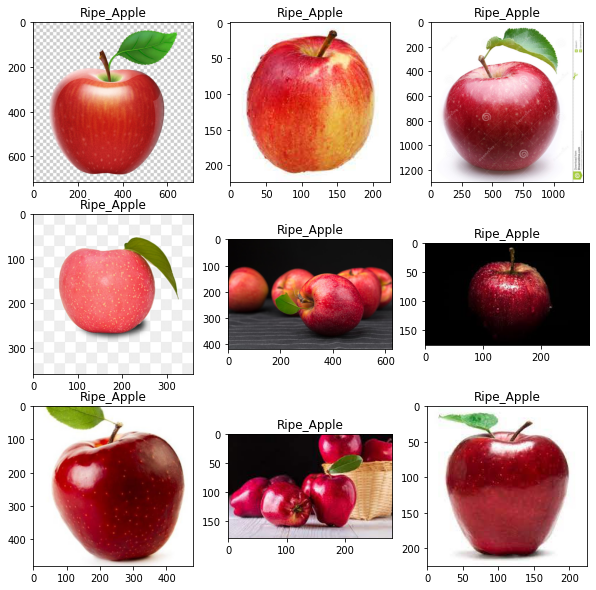

In [94]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/Ripe_Apple",Ripe_Apple[i])),cmap='gray')
    plt.title("Ripe_Apple")
plt.show()


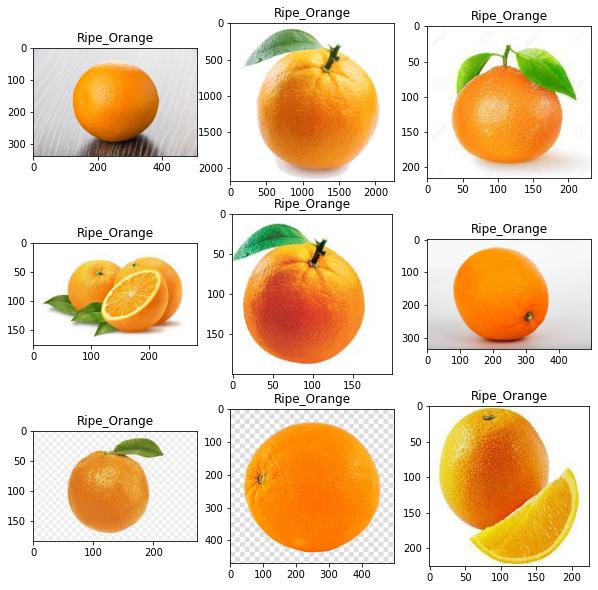

In [97]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/Ripe_Orange",Ripe_Orange[i])),cmap='gray')
    plt.title("Ripe_Orange")
plt.show()

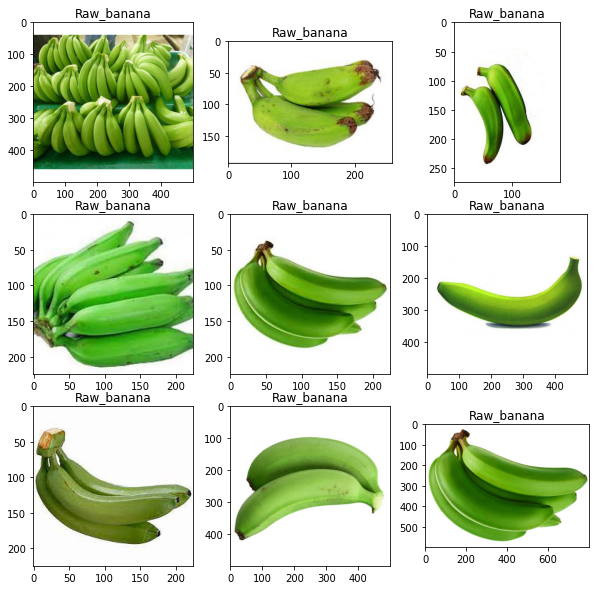

In [98]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/Raw_banana",Raw_banana[i])),cmap='gray')
    plt.title("Raw_banana")
plt.show()

In [99]:
image_size = 224 
BATCH_SIZE = 16 
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

#data_path = './My Drive'

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory( './train',
                                                 target_size = (image_size, image_size),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

testing_set = test_datagen.flow_from_directory( './test',
                                             target_size = (image_size, image_size),
                                             batch_size = BATCH_SIZE,
                                             class_mode = 'categorical',
                                             shuffle = True)

Found 384 images belonging to 6 classes.
Found 133 images belonging to 6 classes.


In [100]:
print("train batch ", training_set.__getitem__(0)[0].shape)
print("test batch ", testing_set.__getitem__(0)[0].shape)
print("sample train label \n", training_set.__getitem__(0)[1][:5])

train batch  (16, 224, 224, 3)
test batch  (16, 224, 224, 3)
sample train label 
 [[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]


In [101]:
training_set.class_indices

{'Raw_Apple': 0,
 'Raw_Orange': 1,
 'Raw_banana': 2,
 'Ripe_Apple': 3,
 'Ripe_Orange': 4,
 'Ripe_banana': 5}

In [102]:
testing_set.class_indices

{'Raw_Apple': 0,
 'Raw_Orange': 1,
 'Raw_banana': 2,
 'Ripe_Apple': 3,
 'Ripe_Orange': 4,
 'Ripe_banana': 5}

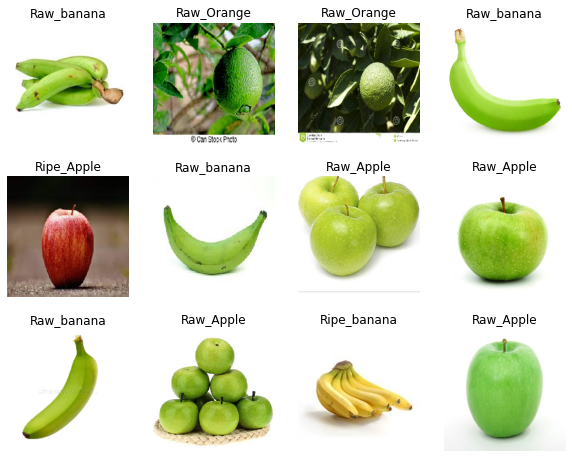

In [104]:
labels = ['Raw_Apple','Raw_Orange','Raw_banana','Ripe_Apple','Ripe_Orange','Ripe_banana']

sample_data = testing_set.__getitem__(1)[0] 
sample_label = testing_set.__getitem__(1)[1] 

plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.imshow(sample_data[i])
    plt.title(labels[np.argmax(sample_label[i])])

In [105]:
!pip install efficientnet
import efficientnet.tfkeras as efn

In [125]:

def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: 
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])


In [126]:
from tensorflow import keras

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

   
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    
    with tf.GradientTape() as tape:
        
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, top_pred_index.numpy()

In [127]:
def superimposed_img(image, heatmap):
    
    heatmap = np.uint8(255 * heatmap)

    
    jet = cm.get_cmap("jet")

    
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image_size, image_size))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    
    superimposed_img = jet_heatmap * 0.4 + image
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

In [128]:
def categorical_smooth_loss(y_true, y_pred, label_smoothing=0.1):
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)
    return loss

In [129]:
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, epsilon=0.0001, patience=3, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [130]:
counter = Counter(training_set.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0}

In [131]:
print(tf.keras.applications.DenseNet201(weights='imagenet').input_shape)
print(efn.EfficientNetB7(weights='imagenet').input_shape) 
print(tf.keras.applications.VGG16(weights='imagenet').input_shape)

(None, 224, 224, 3)
(None, 600, 600, 3)
(None, 224, 224, 3)


In [ ]:

pretrained_vgg = tf.keras.applications.VGG16(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

for layer in pretrained_vgg.layers:
  layer.trainable = False

x3 = pretrained_vgg.output
x3 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x3)
x3 = tf.keras.layers.Flatten(name="flatten_head")(x3)
x3 = tf.keras.layers.Dense(128, activation="relu", name="dense_head")(x3)
x3 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x3)
x3 = tf.keras.layers.Dense(64, activation="relu", name="dense_head_2")(x3)
x3 = tf.keras.layers.Dropout(0.5, name="dropout_head_2")(x3)
model_out = tf.keras.layers.Dense(6, activation='softmax', name="predictions_head")(x3)

model_vgg = Model(inputs=pretrained_vgg.input, outputs=model_out)
model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=categorical_smooth_loss,metrics=['accuracy'])

model_vgg.summary()


In [133]:
history_vgg = model_vgg.fit_generator(training_set, validation_data=testing_set, callbacks=[lr_reduce, es_callback], epochs=20)  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
24/24 [==============================] - 112s 5s/step - loss: 2.1096 - accuracy: 0.1940 - val_loss: 1.6690 - val_accuracy: 0.4060
Epoch 2/20
24/24 [==============================] - 8s 340ms/step - loss: 1.7662 - accuracy: 0.2190 - val_loss: 1.5780 - val_accuracy: 0.5338
Epoch 3/20
24/24 [==============================] - 8s 336ms/step - loss: 1.7323 - accuracy: 0.2560 - val_loss: 1.4766 - val_accuracy: 0.5414
Epoch 4/20
24/24 [==============================] - 8s 337ms/step - loss: 1.5717 - accuracy: 0.3771 - val_loss: 1.3828 - val_accuracy: 0.5940
Epoch 5/20
24/24 [==============================] - 8s 334ms/step - loss: 1.5432 - accuracy: 0.3927 - val_loss: 1.3214 - val_accuracy: 0.6992
Epoch 6/20
24/24 [==============================] - 8s 336ms/step - loss: 1.5273 - accuracy: 0.4341 - val_loss: 1.2615 - val_accuracy: 0.7519
Epoch 7/20
24/24 [==============================] - 8s 336ms/step - loss: 1.4133 - accuracy: 0.4770 - val_loss: 1.2104 - val_accuracy: 0.6992
Epoch 8

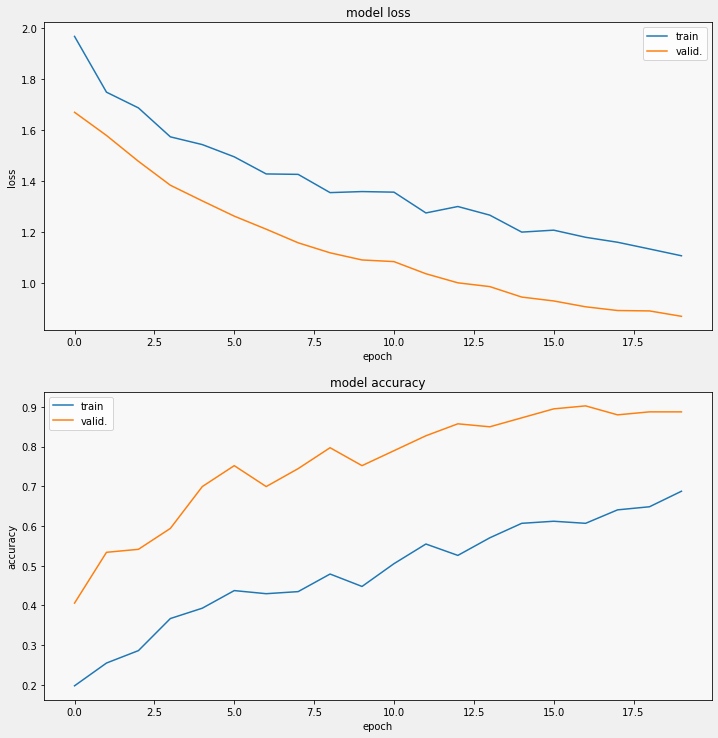

In [134]:
display_training_curves(history_vgg.history['loss'], history_vgg.history['val_loss'], 'loss', 211)
display_training_curves(history_vgg.history['accuracy'], history_vgg.history['val_accuracy'], 'accuracy', 212)

In [135]:
last_conv_layer_name = "block5_pool"
classifier_layer_names = [
    "averagepooling2d_head",
    "flatten_head",
    "dense_head",
    "dropout_head",
    "dense_head_2",
    "dropout_head_2",
    "predictions_head"
]

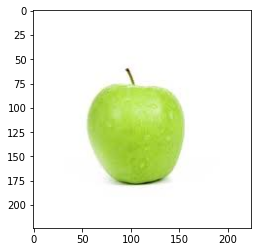

In [183]:
test_image = cv2.imread('./test/Raw_Apple/76.jpg')
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)

In [184]:
heatmap, top_index = make_gradcam_heatmap(test_image, model_vgg, last_conv_layer_name, classifier_layer_names)
print("predicted as", labels[top_index])



predicted as Raw_Apple


In [142]:
model_vgg.save("model_vgg_30_09286.h5")

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
testing_set1 = test_datagen.flow_from_directory( './test',
                                             target_size = (image_size, image_size),
                                             batch_size = 1,
                                             class_mode = 'categorical',
                                             shuffle = True)
print(len(testing_set1))
#print(len(testing_set.data))
#print(testing_set.__iter__())
print(len(testing_set.labels))
print(testing_set.labels)
print(len(testing_set.class_indices))


prediction =model_vgg.predict(testing_set1)
prediction=np.argmax(prediction,axis=1)
prediction =(np.round(prediction))
prediction=prediction.astype(int)
prediction = prediction.reshape(1, -1)[0]
print(len(prediction))
print(prediction)
cm=confusion_matrix(testing_set.labels,prediction)
print('confusion_matrix  :\n',cm)
plt.figure(figsize=(16,12))
ax= plt.subplot()
sns.heatmap((cm), annot=True,fmt=".0f",ax = ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Raw_Apple','Raw_Orange','Raw_banana','Ripe_Apple','Ripe_Orange','Ripe_banana']); ax.yaxis.set_ticklabels(['Raw_Apple','Raw_Orange','Raw_banana','Ripe_Apple','Ripe_Orange','Ripe_banana']);

In [185]:
import http.client
import urllib
import time
print()

#Assign ThingSpeak read API key to a variable
apiKey = 'GOP7ZB9K9GGATXWZ'
if(labels[top_index]=='Raw_Apple'):
  params = urllib.parse.urlencode({'field1': 1, 'key':apiKey})
  headers = {"Content-type": "application/x-www-form-urlencoded","Accept": "text/plain"}
  conn = http.client.HTTPConnection("api.thingspeak.com:80")
if(labels[top_index]=='Raw_Orange'):
  params = urllib.parse.urlencode({'field1': 2, 'key':apiKey})
  headers = {"Content-type": "application/x-www-form-urlencoded","Accept": "text/plain"}
  conn = http.client.HTTPConnection("api.thingspeak.com:80")
if(labels[top_index]=='Raw_banana'):
  params = urllib.parse.urlencode({'field1': 3, 'key':apiKey})
  headers = {"Content-type": "application/x-www-form-urlencoded","Accept": "text/plain"}
  conn = http.client.HTTPConnection("api.thingspeak.com:80")
if(labels[top_index]=='Ripe_Apple'):
  params = urllib.parse.urlencode({'field1': 4, 'key':apiKey})
  headers = {"Content-type": "application/x-www-form-urlencoded","Accept": "text/plain"}
  conn = http.client.HTTPConnection("api.thingspeak.com:80")
if(labels[top_index]=='Ripe_Orange'):
  params = urllib.parse.urlencode({'field1': 5, 'key':apiKey})
  headers = {"Content-type": "application/x-www-form-urlencoded","Accept": "text/plain"}
  conn = http.client.HTTPConnection("api.thingspeak.com:80")
if(labels[top_index]=='Ripe_banana'):
  params = urllib.parse.urlencode({'field1': 6, 'key':apiKey})
  headers = {"Content-type": "application/x-www-form-urlencoded","Accept": "text/plain"}
  conn = http.client.HTTPConnection("api.thingspeak.com:80")
try:
  print("Attempting to contact ThingSpeak")
  conn.request("POST", "/update", params, headers)
  response = conn.getresponse()
  print ("Upload status: ", response.status, response.reason)
  conn.close()
except:
  print("Connection failed")




Attempting to contact ThingSpeak
Upload status:  200 OK
